![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/05/logo-upv-horizontal.png)
![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/06/logos-perte-chip-1024x119.png)

# Laboratory 4. Circuit Tuning

Students: Joan Aroca Sánchez, Jaime Bachero Fernández, David Alcarria Pedro

 ## 0. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import sax
from matplotlib.pyplot import cm

from shapely.geometry import LineString, Polygon
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.thermal import solve_thermal

from scipy.constants import c as c0

import gplugins.sax as gs
import gplugins.tidy3d as gt
from gplugins.common.config import PATH
from collections import OrderedDict



OSError: libGLU.so.1: cannot open shared object file: No such file or directory

## LO1. Phase Shifter Model 

**Phase shifters** are active photonic devices that enable phase modulation of photonic signals. Phase shifters can also be used to “tune” light signals, or in other words, adjust the phase of the signal as it travels through a waveguide. Generally phase shifters can be categorized as modulators or tuners. 

**Thermal phase shifters** are phase shifters that operate based on the thermo-optic effect. For most materials, as a material increases in temperature, the material expands as the molecules of the material shift away from each other. As the molecules of the material shift away from each other, the material’s index of refraction increases. At low temperatures, the relationship between temperature and refractive index is generally linear, but at higher temperatures, the relationship must be approximated using second order differential equations.

**The phase shift of light through a thermal phase shifter is proportional to the index of refraction of the thermal phase shifter, which in turn is proportional to its temperature. Therefore, the phase shift of a thermal phase shifter can be adjusted by changing its temperature.** There are several ways of implementing a thermal phase shifter. Some thermal phase shifters comprise waveguides in proximity to metal resistors. As an electrical current runs through the resistor, the resistor dissipates power in the form of heat, changing the temperature of the waveguide.

In this section we will extract the behavior of the latter described case, a metal resistor directly above the waveguide:

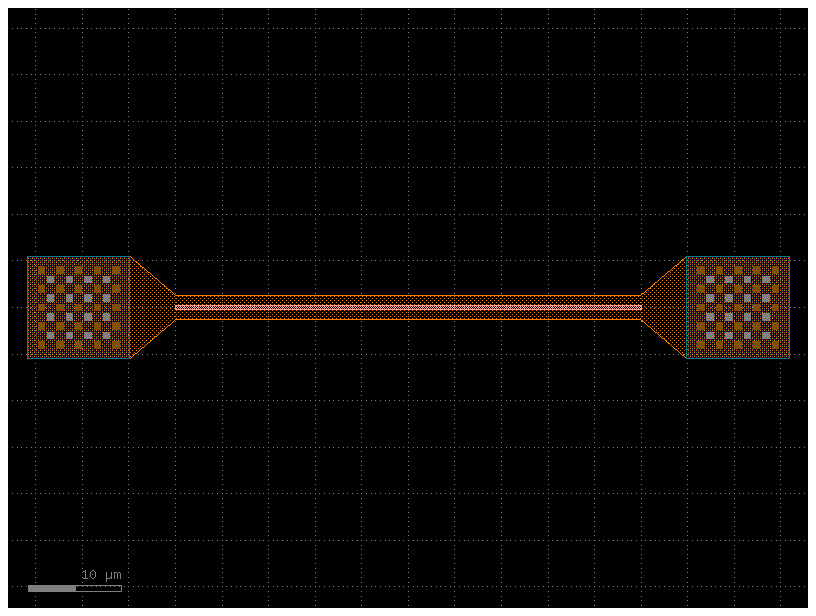

In [41]:
gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

heater = gf.components.straight_heater_metal(length=50)
heater.plot()

In [42]:
LAYER_STACK = PDK.layer_stack

LAYER_STACK.layers["heater"].thickness = 0.13
LAYER_STACK.layers["heater"].zmin = 2.2

s = heater.to_3d()
s.show()

<IPython.core.display.HTML object>

To simulate its behavior, we need to 'build' the cross-section in a heat-transport simulator as the one provided by [FEMWELL](https://helgegehring.github.io/femwell/install.html). The next two cells will allow us to obtain a temperature profile of the material cross-section when a current is applied directly to the metal on top of the waveguide. Using this temperature profile is possible to obtain the effective index change. 

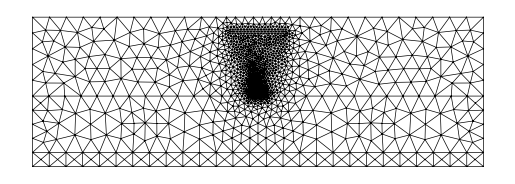

In [43]:
# SOI
w_sim = 8 * 2
h_clad = 2.8    #SiO2 (cladding superior)
h_box = 2       #SiO2 (Buried Oxide)
w_core = 0.5
h_core = 0.22   #Si
h_heater = 0.14
w_heater = 2
offset_heater = 2 + (h_core + h_heater) / 2
h_silicon = 0.5

polygons = OrderedDict(
    bottom=LineString(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
    core=Polygon(
        [
            (-w_core / 2, -h_core / 2),
            (-w_core / 2, h_core / 2),
            (w_core / 2, h_core / 2),
            (w_core / 2, -h_core / 2),
        ]
    ),
    heater=Polygon(
        [
            (-w_heater / 2, -h_heater / 2 + offset_heater),
            (-w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, -h_heater / 2 + offset_heater),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    wafer=Polygon(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
)

resolutions = dict(
    core={"resolution": 0.04, "distance": 1},
    clad={"resolution": 0.6, "distance": 1},
    box={"resolution": 0.6, "distance": 1},
    heater={"resolution": 0.1, "distance": 1},
)

mesh = from_meshio(
    mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6)
)
mesh.draw().show()      

 95%|█████████▌| 20/21 [00:06<00:00,  2.69it/s]

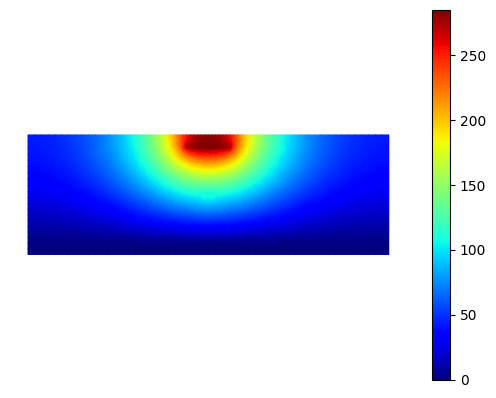

C:\Users\arjoa\AppData\Local\Temp\ipykernel_27144\1027070496.py:38: DeprecationWarning: The behavior of passing an array directly to `show` is deprecated and will be removed in the future. Use `plot` instead.
  modes[0].show(modes[0].E.real)


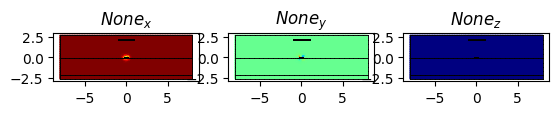

100%|██████████| 21/21 [00:07<00:00,  2.63it/s]


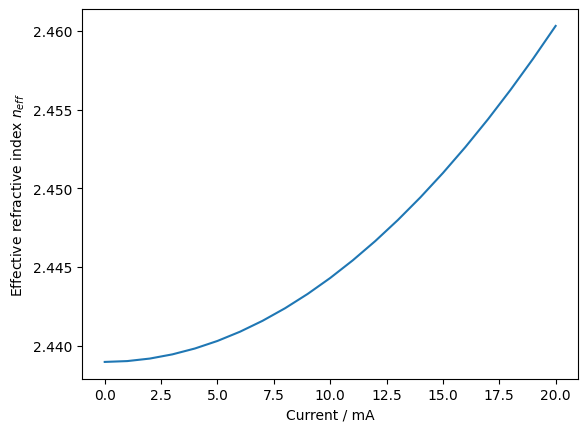

In [44]:
currents = np.linspace(0.0, 20e-3, 21)
current_densities = currents / polygons["heater"].area
neffs = []

for current_density in tqdm(current_densities):
    basis0 = Basis(mesh, ElementTriP0(), intorder=4)
    thermal_conductivity_p0 = basis0.zeros()
    for domain, value in {
        "core": 90,
        "box": 1.38,
        "clad": 1.38,
        "heater": 28,
        "wafer": 148,
    }.items():
        thermal_conductivity_p0[basis0.get_dofs(elements=domain)] = value
    thermal_conductivity_p0 *= 1e-12  # 1e-12 -> conversion from 1/m^2 -> 1/um^2

    basis, temperature = solve_thermal(
        basis0,
        thermal_conductivity_p0,
        specific_conductivity={"heater": 2.3e6},
        current_densities={"heater": current_density},
        fixed_boundaries={"bottom": 0},
    )

    if current_density == current_densities[-1]:
        basis.plot(temperature, shading="gouraud", colorbar=True)
        plt.show()

    temperature0 = basis0.project(basis.interpolate(temperature))
    epsilon = basis0.zeros() + (1.444 + 1.00e-5 * temperature0) ** 2
    epsilon[basis0.get_dofs(elements="core")] = (3.4777 + 1.86e-4 * temperature0[basis0.get_dofs(elements="core")]) ** 2
    # basis0.plot(epsilon, colorbar=True).show()

    modes = compute_modes(basis0, epsilon, wavelength=1.55, num_modes=1, solver="scipy")

    if current_density == current_densities[-1]:
        modes[0].show(modes[0].E.real)

    neffs.append(np.real(modes[0].n_eff))

plt.xlabel("Current / mA")
plt.ylabel("Effective refractive index $n_{eff}$")
plt.plot(currents * 1e3, neffs)
plt.show()

La linealidad se puede cambiar ajustando la distancia entre el heater y la guía

What would be the **phase difference** of a light pulse that propagates through the waveguide (compared with the no current injected case), after a certain length? 

$$\Delta \phi = \frac{2\pi}{\lambda_0}\Delta n_{eff}L $$

Calculate the length of the waveguide needed to obtain a $\pi$	phase shift. 
$$L_\pi = \frac{\lambda_0}{2\Delta n_{eff}} $$

In [45]:
L_pi = 1.55/(2*(neffs[-1] - neffs[0]))
print(L_pi)

36.3080415251551


In [46]:
ps_length  = L_pi   # um
print(f"Phase shift: {2 * np.pi / 1.55 * (neffs[-1] - neffs[0]) * ps_length}")

Phase shift: 3.1415926535897936


## LO2. Tuning Mach-Zehnder Interferometers

Now, let's explore how to use the phase shifter to tune MZI circuits. We will use the results from LO1 as starting point. 

Also, let's consider how an **actual** fabricated device will look like. For this, we will use a PCELL from the Generic PDK of GDSfactory. You can find a detailed description in the [Reference Manual](https://gdsfactory.github.io/gdsfactory/components.html#gdsfactory.components.mzis.mzi_phase_shifter)

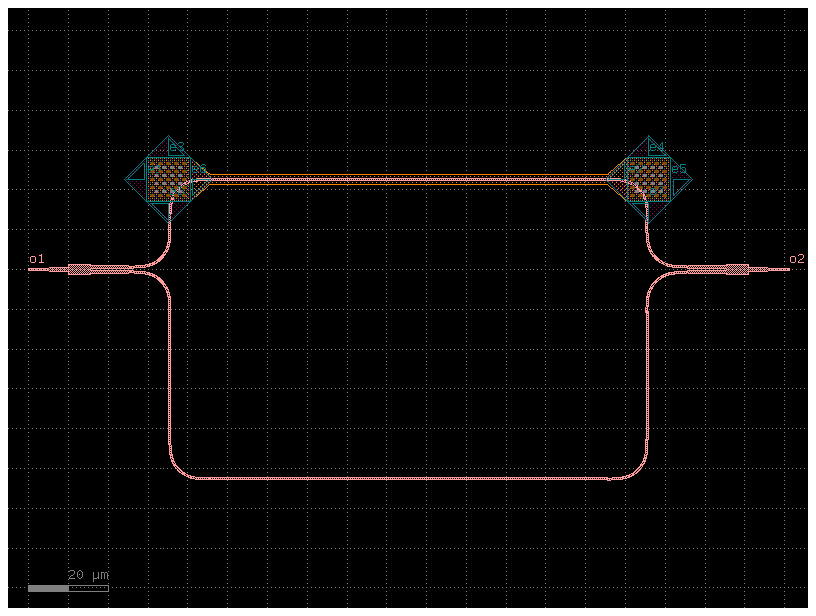

In [47]:
# Relevant parameters to build the MZI

dL = 60 # Path Length difference of the MZI - 0 if balanced

ps_length = 100 # Length of the phase shifter 


c = gf.components.mzi_phase_shifter(delta_length=dL, length_x=ps_length)

c.draw_ports()
c.plot()

We now want to simulate this circuit. We could manually create the circuit (as in Laboratory 3), but it is possible also to automatically extract the connections between components using some functions from the GDSfactory library: 

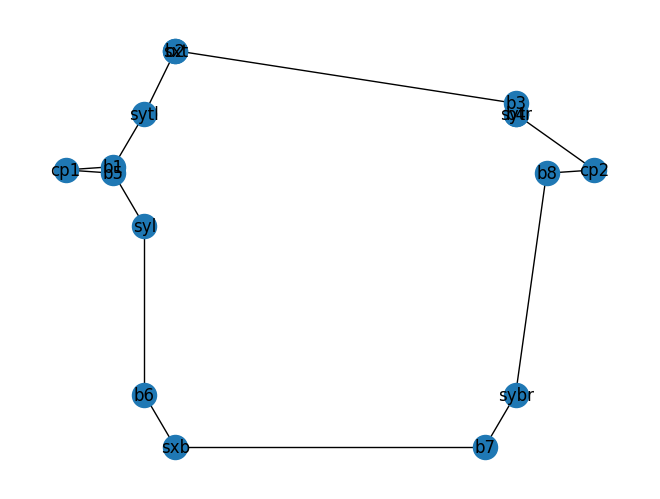

In [48]:
c.plot_netlist()

netlist = sax.netlist(c.get_netlist())

If this view its not clear enough, you can still access to the dictionaries that contain all the relevant information: 

In [49]:
print(c.get_netlist())

{'nets': ({'p1': 'b1,o1', 'p2': 'cp1,o2'}, {'p1': 'b1,o2', 'p2': 'sytl,o1'}, {'p1': 'b2,o1', 'p2': 'sxt,o1'}, {'p1': 'b2,o2', 'p2': 'sytl,o2'}, {'p1': 'b3,o1', 'p2': 'sytr,o2'}, {'p1': 'b3,o2', 'p2': 'sxt,o2'}, {'p1': 'b4,o1', 'p2': 'sytr,o1'}, {'p1': 'b4,o2', 'p2': 'cp2,o2'}, {'p1': 'b5,o1', 'p2': 'cp1,o3'}, {'p1': 'b5,o2', 'p2': 'syl,o1'}, {'p1': 'b6,o1', 'p2': 'syl,o2'}, {'p1': 'b6,o2', 'p2': 'sxb,o1'}, {'p1': 'b7,o1', 'p2': 'sxb,o2'}, {'p1': 'b7,o2', 'p2': 'sybr,o1'}, {'p1': 'b8,o1', 'p2': 'cp2,o3'}, {'p1': 'b8,o2', 'p2': 'sybr,o2'}), 'instances': {'b1': {'component': 'bend_euler', 'info': {'length': 16.637, 'dy': 10, 'min_bend_radius': 7.061, 'radius': 10, 'width': 0.5, 'route_info_type': 'strip', 'route_info_length': 16.637, 'route_info_weight': 16.637, 'route_info_strip_length': 16.637, 'route_info_n_bend_90': 1, 'route_info_min_bend_radius': 7.061}, 'settings': {'radius': None, 'angle': 90, 'p': 0.5, 'with_arc_floorplan': True, 'npoints': None, 'angular_step': None, 'layer': No

In [50]:
print(netlist)

{'top_level': {'nets': ({'p1': 'b1,o1', 'p2': 'cp1,o2'}, {'p1': 'b1,o2', 'p2': 'sytl,o1'}, {'p1': 'b2,o1', 'p2': 'sxt,o1'}, {'p1': 'b2,o2', 'p2': 'sytl,o2'}, {'p1': 'b3,o1', 'p2': 'sytr,o2'}, {'p1': 'b3,o2', 'p2': 'sxt,o2'}, {'p1': 'b4,o1', 'p2': 'sytr,o1'}, {'p1': 'b4,o2', 'p2': 'cp2,o2'}, {'p1': 'b5,o1', 'p2': 'cp1,o3'}, {'p1': 'b5,o2', 'p2': 'syl,o1'}, {'p1': 'b6,o1', 'p2': 'syl,o2'}, {'p1': 'b6,o2', 'p2': 'sxb,o1'}, {'p1': 'b7,o1', 'p2': 'sxb,o2'}, {'p1': 'b7,o2', 'p2': 'sybr,o1'}, {'p1': 'b8,o1', 'p2': 'cp2,o3'}, {'p1': 'b8,o2', 'p2': 'sybr,o2'}), 'instances': {'b1': {'component': 'bend_euler', 'info': {'length': 16.637, 'dy': 10, 'min_bend_radius': 7.061, 'radius': 10, 'width': 0.5, 'route_info_type': 'strip', 'route_info_length': 16.637, 'route_info_weight': 16.637, 'route_info_strip_length': 16.637, 'route_info_n_bend_90': 1, 'route_info_min_bend_radius': 7.061}, 'settings': {'radius': None, 'angle': 90, 'p': 0.5, 'with_arc_floorplan': True, 'npoints': None, 'angular_step': Non

Please note that you will need to define the **models** (component functions) of all the elements on the netlist. Check all the 'component' fields defined in the two netlists. You will need to program the following functions: 

1. straight : for all the straight sections
2. straight_heater_metal_undercut : for the heater section
3. bend : for the bent sections (You could use the same model as the straight section)
4. mmi1x2 : i/o coupler model

In [51]:
# IMPORTANT! Redefine the models I left you on this section 
# Consider a better model for the coupler and waveguide, at least
# Note that the port names in this case are "o1" "o2" - rather than "in0" "out0"

def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2() -> sax.SDict:
    """Returns a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0) -> sax.SDict:
    """Returns bend Sparameters with reduced transmission compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}

# IMPORTANT! 
# In this model I left a "Voltage" variable that will shift the spectrum 
# You MUST update this model with your LO1 results. You can calculate the 
# phase shift for a certain length using the effective index vs current results
def phase_shifter_heater(
    wl: float = 1.55,
    neff: float = 2.34,
    voltage: float = 0,
    length: float = 10,
    loss: float = 0.0,
) -> sax.SDict:
    """Returns simple phase shifter model."""
    deltaphi = voltage * jnp.pi
    phase = 2 * jnp.pi * neff * length / wl + deltaphi
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
            ("l_e1", "r_e1"): 0.0,
            ("l_e2", "r_e2"): 0.0,
            ("l_e3", "r_e3"): 0.0,
            ("l_e4", "r_e4"): 0.0,
        }
    )

models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
    "straight_heater_metal_undercut": phase_shifter_heater,
}

With everything ready, we can now simulate the MZI as in LAB3. 

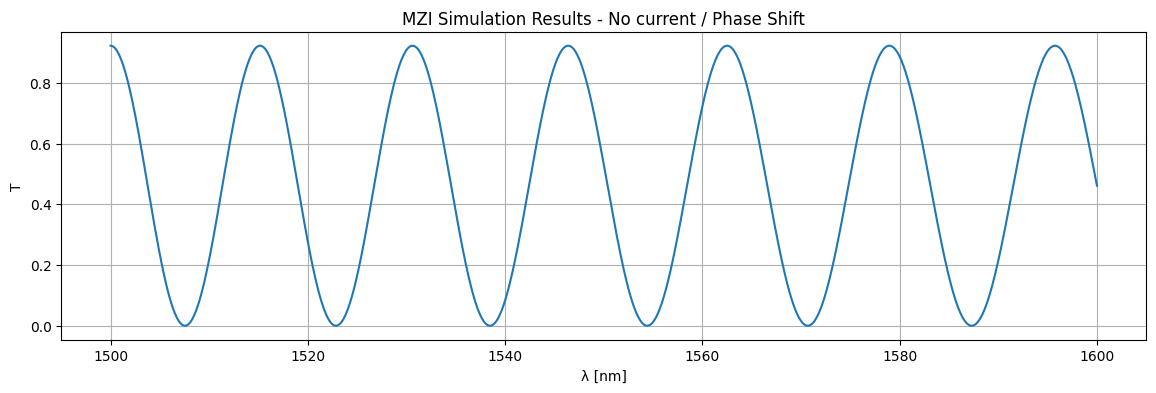

In [52]:
wl = np.linspace(1.5, 1.6, 1001)
mzi_circuit, _ = sax.circuit(netlist=netlist, models=models, backend="filipsson_gunnar")
S = mzi_circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI Simulation Results - No current / Phase Shift")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

With the basic model, we can tune the MZI response directly using the 'voltage' value: 

Text(0.5, 1.0, 'MZI vs voltage')

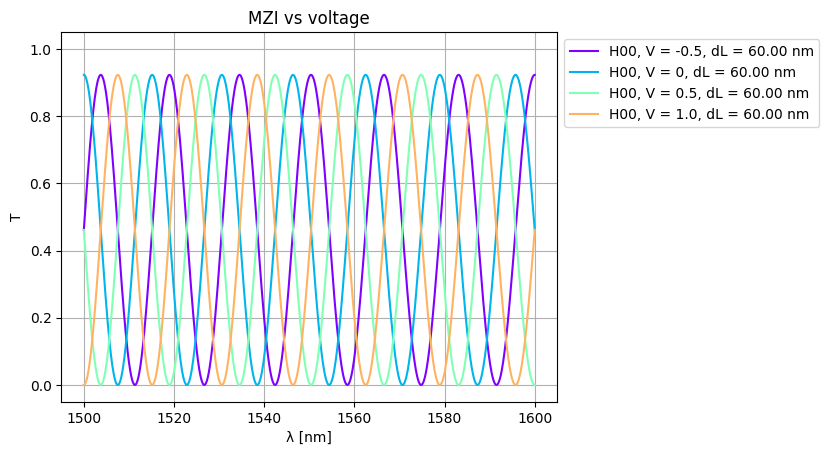

In [53]:
voltages = np.linspace(-1, 1, num=5)
voltages = [-0.5, 0, 0.5, 1.0]
color = cm.rainbow(np.linspace(0, 1, 5))

for i, voltage in enumerate(voltages):
    S = mzi_circuit(
        wl=wl,
        sxt={"voltage": voltage},
    )
    plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2,  color=color[i], label=f"H00, V = {voltage}, dL = {dL:.2f} nm")
    plt.xlabel("λ [nm]")
    plt.ylabel("T")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("MZI vs voltage")

Text(0.5, 1.0, 'MZI vs voltage')

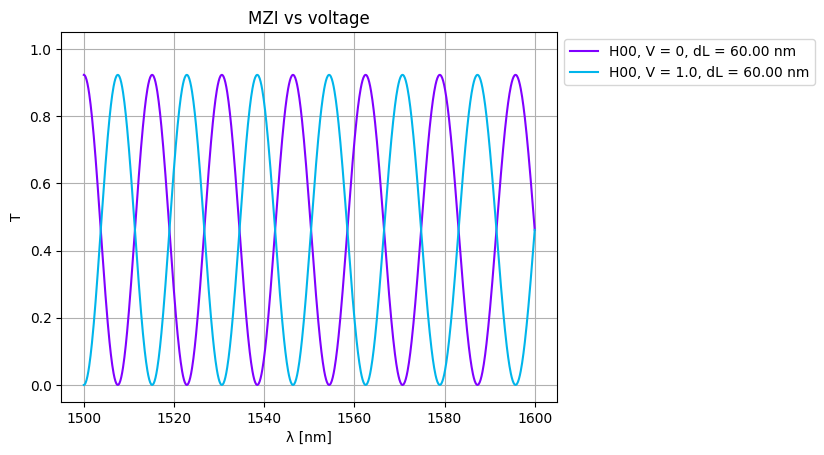

In [54]:
voltages = np.linspace(-1, 1, num=5)
voltages = [0, 1.0]
color = cm.rainbow(np.linspace(0, 1, 5))

for i, voltage in enumerate(voltages):
    S = mzi_circuit(
        wl=wl,
        sxt={"voltage": voltage},
    )
    plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2,  color=color[i], label=f"H00, V = {voltage}, dL = {dL:.2f} nm")
    plt.xlabel("λ [nm]")
    plt.ylabel("T")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("MZI vs voltage")

Now: 

1. Modify your models with the instructions left in the Models section. 
2. Simulate your MZI response when different currents are applied to the metal heater on top of the waveguide. 

## Solution

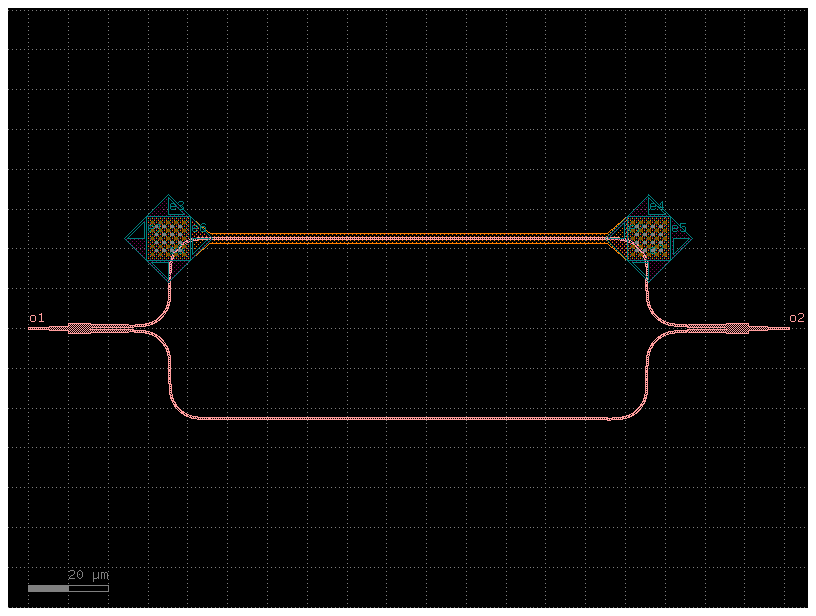

In [61]:
# Relevant parameters to build the MZI

dL = 0 # Path Length difference of the MZI - 0 if balanced

ps_length = 100 # Length of the phase shifter 


c = gf.components.mzi_phase_shifter(delta_length=dL, length_x=ps_length)

c.draw_ports()
c.plot()

In [62]:
# IMPORTANT! Redefine the models I left you on this section 
# Consider a better model for the coupler and waveguide, at least
# Note that the port names in this case are "o1" "o2" - rather than "in0" "out0"

def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2() -> sax.SDict:
    """Returns a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0) -> sax.SDict:
    """Returns bend Sparameters with reduced transmission compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}

# IMPORTANT! 
# In this model I left a "Voltage" variable that will shift the spectrum 
# You MUST update this model with your LO1 results. You can calculate the 
# phase shift for a certain length using the effective index vs current results
def phase_shifter_heater(
    wl: float = 1.55,
    neff: float = 2.34,
    voltage: int = 0,
    length: float = 10,
    loss: float = 0.0,
) -> sax.SDict:
    """Returns simple phase shifter model."""
    deltaphi = 2 * np.pi / 1.55 * (neffs[voltage] - neffs[0]) * length
    phase = 2 * jnp.pi * neff * length / wl + deltaphi
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
            ("l_e1", "r_e1"): 0.0,
            ("l_e2", "r_e2"): 0.0,
            ("l_e3", "r_e3"): 0.0,
            ("l_e4", "r_e4"): 0.0,
        }
    )

models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
    "straight_heater_metal_undercut": phase_shifter_heater,
}

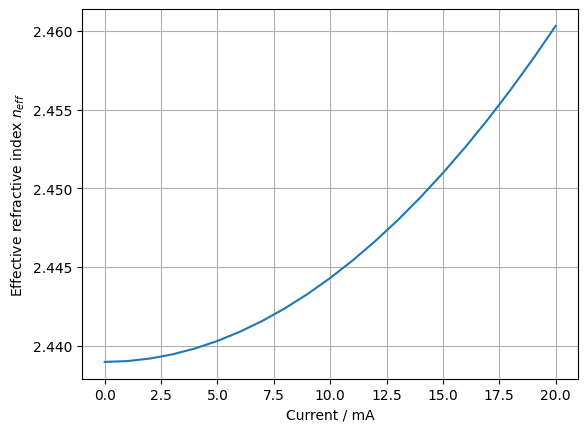

In [63]:
plt.xlabel("Current / mA")
plt.ylabel("Effective refractive index $n_{eff}$")
plt.plot(currents * 1e3, neffs)
plt.grid()
plt.show()

Text(0.5, 1.0, 'MZI vs voltage')

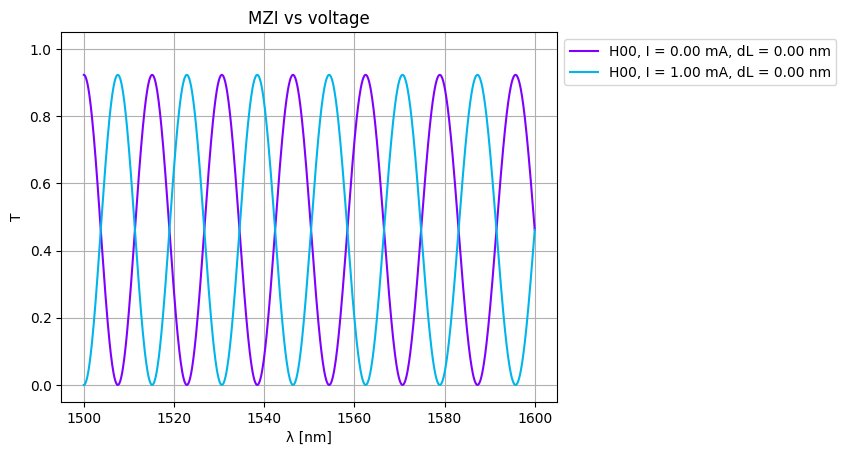

In [64]:
voltages = [0, 1] # Current
color = cm.rainbow(np.linspace(0, 1, 5))

for i, voltage in enumerate(voltages):
    S = mzi_circuit(
        wl=wl,
        sxt={"voltage": voltage},
    )
    plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2,  color=color[i], label=f"H00, I = {currents[voltage]*1e3:.2f} mA, dL = {dL:.2f} nm")
    plt.xlabel("λ [nm]")
    plt.ylabel("T")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("MZI vs voltage")

### Pasos
1. Aplicar densidad de corriente
2. Resolver la propagación de calor
3. Calucular la temperatura de la guía
4. Resolver n_eff